In [13]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import re
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords
from bnlp.corpus import punctuations

In [21]:
df=pd.read_excel('updated_data.xlsx')
df = df.sample(frac=1)

In [109]:
a = df[df['isAbusive'] == 0]['isAbusive'].value_counts()[0]
b = df[df['isAbusive'] == 1]['isAbusive'].value_counts()[1]

print('Non Abusive = ', a)
print('Abusive     = ', b)

Non Abusive =  5964
Abusive     =  4254


<BarContainer object of 2 artists>

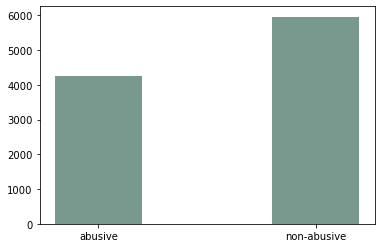

In [110]:
import matplotlib.pyplot as plt

data = {'abusive':b, 'non-abusive':a}

classes = list(data.keys())
values = list(data.values())

plt.bar(classes, values, color ='#7a998e',width = 0.4)

In [3]:
# removing mentions, links, tags

def removing_mentions(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)     # removing @mentions
    text = re.sub(r'@[A-Za-zA-Z0-9]+', '', text)  # removing @mentions 
    text = re.sub(r'@[A-Za-z]+', '', text)        # removing @mentions
    text = re.sub(r'@[-)]+', '', text)            # removing @mentions

    return text

def removeing_links(text):
    text = re.sub(r'https?\/\/\S+', '', text)     # removing the hyper link
    text = re.sub(r'http?\/\/\S+', '', text)     # removing the hyper link
    
    return text

def removing_tags(text):
    text = re.sub(r'#', '', text )              # removing '#' sign
    text = re.sub(r'RT[\s]+', '', text)         # removing RT
    text = re.sub(r'&[a-z;]+', '', text)        # removing '&gt;'
    
    return text

In [7]:
# removing stopwords

def remove_stopwords(text):
    tokenizer = BasicTokenizer()
    words = tokenizer.tokenize(text)
    filtered_words = [w for w in words if not w in stopwords]

    str = " "
    return str.join(filtered_words)

In [8]:
print("Some Bangla Stopwords...")
print(stopwords[10:20])

Some Bangla Stopwords...
['অবশ্য', 'অর্থাত', 'আই', 'আগামী', 'আগে', 'আগেই', 'আছে', 'আজ', 'আদ্যভাগে', 'আপনার']


In [9]:
#removing punctuation

def remove_punctuations(text):
    tokenizer = BasicTokenizer()
    words = tokenizer.tokenize(text)
    punct_list = tokenizer.tokenize(punctuations)
    filtered_words = [w for w in words if not w in punct_list]
    
    str = " "
    return str.join(filtered_words)

In [10]:
print("some Punctuations...")
print(BasicTokenizer().tokenize(punctuations))

some Punctuations...
['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '।', 'ঃ']


In [23]:
print("Before preprocessing")
df[df['isAbusive'] == 0][['comment_text', 'isAbusive']].head()

before preprocessing


,comment_text,isAbusive
4370,কাকু মাজে মধ্যে এমন কথা ভলে কাকু নিজেও জানে না...,0
9492,কিছুক্ষণ ভাবার টাইম অন্তত পাওয়া গেলো,0
6798,উঁহু,0
4351,মতের আর মূল্য কৈ ?,0
4583,সে কোন দেশের লোক?,0


In [25]:
df['comment_text'] = df['comment_text'].apply(removing_mentions)
df['comment_text'] = df['comment_text'].apply(removeing_links)
df['comment_text'] = df['comment_text'].apply(removing_tags)
df['comment_text'] = df['comment_text'].apply(remove_stopwords)
df['comment_text'] = df['comment_text'].apply(remove_punctuations)

In [26]:
print("After preprocessing")
df[df['isAbusive'] == 0][['comment_text', 'isAbusive']].head()

After preprocessing


,comment_text,isAbusive
4370,কাকু মাজে কথা ভলে কাকু নিজেও জানে ভলে,0
9492,কিছুক্ষণ ভাবার টাইম পাওয়া গেলো,0
6798,উঁহু,0
4351,মতের মূল্য কৈ,0
4583,দেশের লোক,0


## Training without kfold 

In [155]:
X_train, X_test, y_train, y_test = train_test_split(df.comment_text,df.isAbusive, test_size = 0.20)

v = TfidfVectorizer()
X_train_vector = v.fit_transform(X_train.values)
X_test_vector = v.transform(X_test.values)
# 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
model = SVC(kernel='rbf')
model.fit(X_train_vector, y_train)
y_pred = model.predict(X_test_vector)


X_test_vector = v.transform(X_test)
score = model.score(X_test_vector, y_test)
print("Accuracy  = ", score*100)
print("Precision = ", precision_score(y_test, y_pred) * 100)
print("F1-Score  = ", f1_score(y_test, y_pred) * 100)

Accuracy  =  84.83365949119374
Precision =  81.17505995203837
F1-Score  =  81.3701923076923


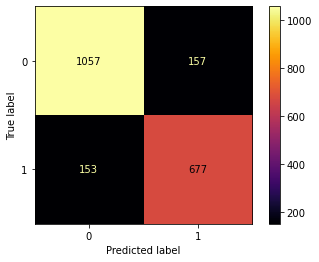

In [157]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test_vector, y_test,cmap='inferno')

## Using Kfold

## SVM with rbf kernel

In [45]:
acc_m_svc = 0.0
f1_m_svc = 0.0
pre_m_svc = 0.0
recall_m_svc = 0.0
n = 6
v = TfidfVectorizer()

x = df.comment_text
y = df.isAbusive


kf = KFold(n_splits=n)
for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
    model = SVC(kernel='rbf')

    X_train_vector = v.fit_transform(X_train.values)
    X_test_vector = v.transform(X_test.values)
    
    model.fit(X_train_vector,y_train)
    
    y_pred = model.predict(X_test_vector)

    acc_m_svc = acc_m_svc + accuracy_score(y_test, y_pred)
    pre_m_svc = pre_m_svc + precision_score(y_test, y_pred,average='weighted')
    f1_m_svc = f1_m_svc + f1_score(y_test, y_pred,average='weighted')
    recall_m_svc = recall_m_svc + recall_score(y_test, y_pred,average='weighted')

    
print("accuracy  : " , acc_m_svc/n)
print("Precision : " , pre_m_svc/n)
print("F1 Score  : " , f1_m_svc/n)
# print("Recall    : " , recall_m_svc/n)

accuracy  :  0.7449598747308671
Precision :  0.9452335523932165
F1 Score  :  0.8236490686794854


## SVM with Linear Kernel

In [47]:
acc_m_svc = 0.0
f1_m_svc = 0.0
pre_m_svc = 0.0
recall_m_svc = 0.0
n = 10
v = TfidfVectorizer()

x = df.comment_text
y = df.isAbusive


kf = KFold(n_splits=n)
for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    
    model = SVC(kernel='linear')

    X_train_vector = v.fit_transform(X_train.values)
    X_test_vector = v.transform(X_test.values)
    
    model.fit(X_train_vector,y_train)
    
    y_pred = model.predict(X_test_vector)

    acc_m_svc = acc_m_svc + accuracy_score(y_test, y_pred)
    pre_m_svc = pre_m_svc + precision_score(y_test, y_pred,average='weighted')
    f1_m_svc = f1_m_svc + f1_score(y_test, y_pred,average='weighted')
    recall_m_svc = recall_m_svc + recall_score(y_test, y_pred,average='weighted')

print("accuracy  : " , acc_m_svc/n)
print("Precision : " , pre_m_svc/n)
print("F1 Score  : " , f1_m_svc/n)
# print("Recall    : " , recall_m_svc/n)

accuracy  :  0.7268659519944185
Precision :  0.9597476465633312
F1 Score  :  0.817202308500986


### Some Testing

In [113]:
text = [
    'অপেক্ষা করেন, সত্যতা বের হয়ে আসবেই',
    'উনার চোখ চকচক করে উঠলো',
    'আজকে ১্টা ল্যাব আছে',
    'কুত্তার বাচ্চা',
    'রফিক নামক লোকটি ইতর',
    'নাস্তিকের বাচ্চা কোথাকার',
    'তুই একটা নাস্তিকর বাচ্চা'
]

preprocessed_text = []
for x in text:
    temp = remove_stopwords(x)
    temp = remove_punctuations(temp)
    preprocessed_text.append(temp)
    print(temp)
    
text_count = v.transform(text)
model.predict(text_count)

অপেক্ষা সত্যতা বের হয়ে আসবেই
উনার চোখ চকচক উঠলো
আজকে ১্টা ল্যাব
কুত্তার বাচ্চা
রফিক নামক লোকটি ইতর
নাস্তিকের বাচ্চা কোথাকার
তুই একটা নাস্তিকর বাচ্চা


array([0, 0, 0, 1, 1, 1, 0], dtype=int64)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(df.comment_text,df.isAbusive, test_size = 0.20)

In [150]:
v = CountVectorizer()
X_test_count = v.fit_transform(X_test.values)

In [151]:
len(X_test_count.toarray()[0])

1393

In [152]:
len(X_test[0])

51

In [154]:
df[df['isAbusive'] == 0][['comment_text', 'isAbusive']]

,comment_text,isAbusive
4370,কাকু মাজে কথা ভলে কাকু নিজেও জানে ভলে,0
9492,কিছুক্ষণ ভাবার টাইম পাওয়া গেলো,0
6798,উঁহু,0
4351,মতের মূল্য কৈ,0
4583,দেশের লোক,0
...,...,...
9022,উল্টা গাড়ির টিস্যু পেপার বক্সের টিস্যু খেয়ে ফে...,0
7129,“ দেশের নির্ধারিত দোযখের গেটে গার্ড ”,0
9239,বললাম ‘ পারবো ’,0
7624,কষ্ট করেছি ডায়াল আপ,0
